<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/38_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libcudnn8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.18.0 requires keras>=3.5.0, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.18.0 requires keras>=3.5.0, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 248.1 kB/s eta 0:00:00


In [ ]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text as text
import re
import pathlib
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import warnings
warnings.filterwarnings("ignore")

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/aztr_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/188396 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/aztr_to_en/incomplete.PPHZ3T_1.0.0/ted_hrlr_translate-t…

Generating validation examples...:   0%|          | 0/671 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/aztr_to_en/incomplete.PPHZ3T_1.0.0/ted_hrlr_translate-v…

Generating test examples...:   0%|          | 0/903 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/aztr_to_en/incomplete.PPHZ3T_1.0.0/ted_hrlr_translate-t…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/aztr_to_en/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_examples = train_examples.take(25000)

In [ ]:
print('Размер обучающей выборки: ', len(train_examples))
print('Размер валидационной выборки: ', len(val_examples))

Размер обучающей выборки:  25000
Размер валидационной выборки:  671


In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    print('Примеры на португальском языке:')
    print()
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))
    print()

    print('Примеры на английском языке:')
    print()
    for en in en_examples.numpy():
        print(en.decode('utf-8'))

Примеры на португальском языке:

bir soru ile başlarsın , düğümleri toplarsın , düğümleri sadeleştirirsin , bunu tekrarlarsın , sadeleştirirsin ve sadeleştirirsin ve şekil oluşur , grup netlik kazanır ve soruyu cevaplarsın .
mll tipi lösemide , şu orta gen grubu , ve aml tipinde , şu alttaki gen grubu çalışır .
başta hesaba katmadığım çok önemli bir faktör de pişirme süresiydi .

Примеры на английском языке:

you start with a question , you collect the nodes , you refine the nodes , you do it over again , you refine and refine and refine , and the patterns emerge , and the group gets clarity and you answer the question .
in mll , it 's the middle set of genes , and in aml , it 's the bottom set of genes .
another important factor that i did n't take into account initially was the time cooked .


In [ ]:
VOCAB_SIZE = 1000
# Параметры токенизатора (lower_case - приводим к нижнему регистру)
bert_tokenizer_params=dict(lower_case=True)

# Определяем токены, с которыми работает токенизатор
# [START] - начало строки
# [END]   - конец строки
# [UNK]   - неизвестное слово
# [PAD]   - используется для выравнивания длин всех предложений
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # Желаемый размер словаря
    vocab_size = VOCAB_SIZE,
    # Токены включаемые в словарь
    reserved_tokens=reserved_tokens,
    # Аргументы для `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Аргументы для `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={}, # не используем, но определяем чтобы не было ошибок
)

In [ ]:
train_en = train_examples.map(lambda pt, en: en)
train_pt = train_examples.map(lambda pt, en: pt)

In [ ]:
pt_vocab = bert_vocab.bert_vocab_from_dataset(
    train_pt.batch(500).prefetch(2),
    **bert_vocab_args)

In [ ]:
print(pt_vocab[:10])
print(pt_vocab[100:110])
print(pt_vocab[1000:1010])
print(pt_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '#', '$', '%', '&', "'"]
['##l', '##s', 'ama', '##in', 'var', '##z', '##li', 'gibi', '##lı', 'olarak']
[]
['##°', '##–', '##—', '##‘', '##’', '##“', '##”', '##€', '##♪', '##♫']


In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
write_vocab_file('pt_vocab.txt', pt_vocab)

In [ ]:
en_vocab = bert_vocab.bert_vocab_from_dataset(
    train_en.batch(500).prefetch(2),
    **bert_vocab_args)

In [ ]:
print(en_vocab[:10])
print(en_vocab[100:110])
print(en_vocab[1000:1010])
print(en_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '#', '$', '%', '&', "'"]
['as', 'not', 'all', 'at', '##er', 'my', 'one', 're', 'like', '##e']
[]
['##^', '##`', '##j', '##q', '##z', '##–', '##—', '##’', '##♪', '##♫']


In [ ]:
write_vocab_file('en_vocab.txt', en_vocab)

In [ ]:
!ls *.txt

en_vocab.txt  pt_vocab.txt


In [ ]:
pt_tokenizer = text.BertTokenizer('pt_vocab.txt', **bert_tokenizer_params)
en_tokenizer = text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)

In [ ]:
print('Отберем строки для примера:')
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for ex in en_examples:
    print(ex.numpy())

Отберем строки для примера:
b'you start with a question , you collect the nodes , you refine the nodes , you do it over again , you refine and refine and refine , and the patterns emerge , and the group gets clarity and you answer the question .'
b"in mll , it 's the middle set of genes , and in aml , it 's the bottom set of genes ."
b"another important factor that i did n't take into account initially was the time cooked ."


In [ ]:
token_batch = en_tokenizer.tokenize(en_examples)
# Объединяем оси word и word-piece и получаем тензор формы (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)

print('Токенизируем отобранные строки:')
for ex in token_batch.to_list():
  print(ex)

Токенизируем отобранные строки:
[76, 361, 91, 37, 430, 14, 76, 39, 698, 211, 280, 68, 178, 401, 72, 14, 76, 107, 277, 244, 68, 178, 401, 72, 14, 76, 90, 75, 216, 414, 14, 76, 107, 277, 244, 69, 107, 277, 244, 69, 107, 277, 244, 14, 69, 68, 52, 249, 415, 375, 41, 186, 104, 227, 14, 69, 68, 644, 151, 72, 39, 194, 223, 158, 69, 76, 779, 68, 430, 16]
[74, 49, 194, 194, 14, 75, 9, 55, 68, 693, 931, 71, 43, 294, 152, 14, 69, 74, 509, 194, 14, 75, 9, 55, 68, 38, 339, 114, 318, 931, 71, 43, 294, 152, 16]
[291, 344, 330, 169, 73, 45, 167, 50, 9, 56, 208, 164, 37, 702, 702, 727, 74, 205, 372, 94, 83, 68, 153, 39, 172, 828, 93, 16]


In [ ]:
words = en_tokenizer.detokenize(token_batch)
print('Проверим обратное преобразование:')

# Объединение полученного тензора в текст, объединяем пробелами
print(tf.strings.reduce_join(words, separator=' ', axis=-1))

Проверим обратное преобразование:
tf.Tensor(
[b'you start with a question , you collect the nodes , you refine the nodes , you do it over again , you refine and refine and refine , and the patterns emerge , and the group gets clarity and you answer the question .'
 b"in mll , it ' s the middle set of genes , and in aml , it ' s the bottom set of genes ."
 b"another important factor that i did n ' t take into account initially was the time cooked ."], shape=(3,), dtype=string)


In [ ]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = pt_tokenizer.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = en_tokenizer.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())

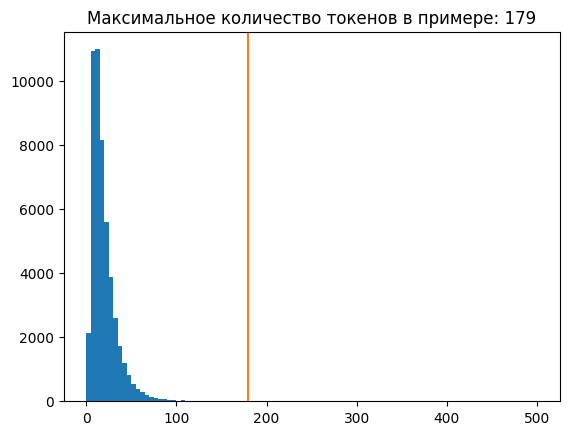

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Максимальное количество токенов в примере: {max_length}');

In [ ]:
MAX_TOKENS=64

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

In [ ]:
words = en_tokenizer.detokenize(add_start_end(token_batch))
tf.strings.reduce_join(words, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'[START] you start with a question , you collect the nodes , you refine the nodes , you do it over again , you refine and refine and refine , and the patterns emerge , and the group gets clarity and you answer the question . [END]',
       b"[START] in mll , it ' s the middle set of genes , and in aml , it ' s the bottom set of genes . [END]",
       b"[START] another important factor that i did n ' t take into account initially was the time cooked . [END]"],
      dtype=object)>

In [ ]:
def cleanup_text(reserved_tokens, token_txt):
  # Удаление токенов, кроме "[UNK]".
  # Поиск зарезервированных токенов кроме [UNK]
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  # "Плохие" токены для регулярки объединяем знаком ИЛИ (|)
  bad_token_re = "|".join(bad_tokens)

  # Ищем в строке регулярку
  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  # Отсеиваем из исходной строки все найденные включения "плохих" токенов
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Сцепление строк.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [ ]:
print('Отберем строки для примера:')
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for ex in en_examples:
    print(ex.numpy())

Отберем строки для примера:
b'you start with a question , you collect the nodes , you refine the nodes , you do it over again , you refine and refine and refine , and the patterns emerge , and the group gets clarity and you answer the question .'
b"in mll , it 's the middle set of genes , and in aml , it 's the bottom set of genes ."
b"another important factor that i did n't take into account initially was the time cooked ."


In [ ]:
en_examples.numpy()

array([b'you start with a question , you collect the nodes , you refine the nodes , you do it over again , you refine and refine and refine , and the patterns emerge , and the group gets clarity and you answer the question .',
       b"in mll , it 's the middle set of genes , and in aml , it 's the bottom set of genes .",
       b"another important factor that i did n't take into account initially was the time cooked ."],
      dtype=object)

In [ ]:
token_batch = en_tokenizer.tokenize(en_examples).merge_dims(-2,-1)
words = en_tokenizer.detokenize(token_batch)
words

<tf.RaggedTensor [[b'you', b'start', b'with', b'a', b'question', b',', b'you', b'collect',
  b'the', b'nodes', b',', b'you', b'refine', b'the', b'nodes', b',', b'you',
  b'do', b'it', b'over', b'again', b',', b'you', b'refine', b'and',
  b'refine', b'and', b'refine', b',', b'and', b'the', b'patterns',
  b'emerge', b',', b'and', b'the', b'group', b'gets', b'clarity', b'and',
  b'you', b'answer', b'the', b'question', b'.']                             ,
 [b'in', b'mll', b',', b'it', b"'", b's', b'the', b'middle', b'set', b'of',
  b'genes', b',', b'and', b'in', b'aml', b',', b'it', b"'", b's', b'the',
  b'bottom', b'set', b'of', b'genes', b'.']                                ,
 [b'another', b'important', b'factor', b'that', b'i', b'did', b'n', b"'",
  b't', b'take', b'into', b'account', b'initially', b'was', b'the', b'time',
  b'cooked', b'.']                                                          ]>

In [ ]:
cleanup_text(reserved_tokens, words).numpy()

array([b'you start with a question , you collect the nodes , you refine the nodes , you do it over again , you refine and refine and refine , and the patterns emerge , and the group gets clarity and you answer the question .',
       b"in mll , it ' s the middle set of genes , and in aml , it ' s the bottom set of genes .",
       b"another important factor that i did n ' t take into account initially was the time cooked ."],
      dtype=object)

In [ ]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    # Определяем токенизатор
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    # Зарезервированные токены
    self._reserved_tokens = reserved_tokens
    # Путь к файлу словаря
    self._vocab_path = tf.saved_model.Asset(vocab_path)
    # Читаем из файла словарь и делим по строкам
    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    # Для экспорта класса необходимо создать так называемые сигнатуры,
    # чтобы tensorflow понимал с какими данными он работает

    # Сигнатура для tokenize (работает с пакетами строк).
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Сигнатура для `detokenize` и `lookup`
    # Могут работать как с `Tensors`, так и `RaggedTensors`
    # с тензорами формы [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # Методы `get_*` не имеют аргументов
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

    # После определения сигнатур можно определить и сами методы класса

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Объединяем оси `word` и `word-piece` (как в примере выше)
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words) # очищаем перед выводом

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids) # возвращаем явное соответствие словаря токенам

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0] # определяем длину словаря по нулевому индексу формы

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path # получение пути к файлу словаря

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens) # получение списка зарезервированных токенов

In [ ]:
tokenizers = tf.Module()
tokenizers.pt = CustomTokenizer(reserved_tokens, 'pt_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.saved_model.save(tokenizers, model_name)

In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 76, 361, 91, 37, 430, 14, 76, 39, 698, 211, 280, 68, 178, 401, 72, 14, 76, 107, 277, 244, 68, 178, 401, 72, 14, 76, 90, 75, 216, 414, 14, 76, 107, 277, 244, 69, 107, 277, 244, 69, 107, 277, 244, 14, 69, 68, 52, 249, 415, 375, 41, 186, 104, 227, 14, 69, 68, 644, 151, 72, 39, 194, 223, 158, 69, 76, 779, 68, 430, 16, 3]
[2, 74, 49, 194, 194, 14, 75, 9, 55, 68, 693, 931, 71, 43, 294, 152, 14, 69, 74, 509, 194, 14, 75, 9, 55, 68, 38, 339, 114, 318, 931, 71, 43, 294, 152, 16, 3]
[2, 291, 344, 330, 169, 73, 45, 167, 50, 9, 56, 208, 164, 37, 702, 702, 727, 74, 205, 372, 94, 83, 68, 153, 39, 172, 828, 93, 16, 3]


In [ ]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

you start with a question , you collect the nodes , you refine the nodes , you do it over again , you refine and refine and refine , and the patterns emerge , and the group gets clarity and you answer the question .
in mll , it ' s the middle set of genes , and in aml , it ' s the bottom set of genes .
another important factor that i did n ' t take into account initially was the time cooked .


In [ ]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'you', b'start', b'with', b'a', b'question', b',', b'you',
  b'c', b'##ol', b'##le', b'##ct', b'the', b'no', b'##de', b'##s', b',',
  b'you', b're', b'##f', b'##ine', b'the', b'no', b'##de', b'##s', b',',
  b'you', b'do', b'it', b'over', b'again', b',', b'you', b're', b'##f',
  b'##ine', b'and', b're', b'##f', b'##ine', b'and', b're', b'##f',
  b'##ine', b',', b'and', b'the', b'p', b'##at', b'##ter', b'##ns', b'e',
  b'##m', b'##er', b'##ge', b',', b'and', b'the', b'group', b'get', b'##s',
  b'c', b'##l', b'##ar', b'##ity', b'and', b'you', b'answer', b'the',
  b'question', b'.', b'[END]']                                             ,
 [b'[START]', b'in', b'm', b'##l', b'##l', b',', b'it', b"'", b's', b'the',
  b'middle', b'set', b'of', b'g', b'##en', b'##es', b',', b'and', b'in',
  b'am', b'##l', b',', b'it', b"'", b's', b'the', b'b', b'##ot', b'##t',
  b'##om', b'set', b'of', b'g', b'##en', b'##es', b'.', b'[END]']          ,
 [b'[START]', b'another', b

In [ ]:
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)   # Токенизируем данные
    pt = pt[:, :MAX_TOKENS]           # Выравнивание данных по MAX_TOKENS.
    pt = pt.to_tensor()               # Преобразуем в тензор с равномерными измерениями

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Удаляем [END] токены (вход декодировщика)
    en_labels = en[:, 1:].to_tensor()   # Удаляем [START] токены (выход декодировщика)

    return (pt, en_inputs), en_labels

In [ ]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)                     # перемешиваем данные
      .batch(BATCH_SIZE)                        # делим датасет на пакеты
      .map(prepare_batch, tf.data.AUTOTUNE)     # применим функцию prepare_batch
      .prefetch(buffer_size=tf.data.AUTOTUNE))  # prefetch используется для разделения времени, когда данные подготавливаются и потребляются, что ускоряет обучение сети

In [ ]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [ ]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 64)
(64, 64)
(64, 64)


In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # форма (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # форма (1, depth)

  angle_rates = 1 / (10000**depths)         # форма (1, depth)
  angle_rads = positions * angle_rates      # форма (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)  # указываем тип возвращаемых данных

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Прверим форму
print(pos_encoding.shape)

(2048, 512)


In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) # эмбеддинг
    self.pos_encoding = positional_encoding(length=2048, depth=d_model) # позиционное кодирование

  # Данный метод возвращает маску эмбеддинга
  # Так как вектора выравниваются до одной длины с помощью pad_sequences,
  # то метод вернет True для ненулевых токенов, и False для нулевых токенов

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)

    # Этот коэффициент задает относительный масштаб встраивания и позиционного кодирования
    # C этим параметром можно и нужно играться!
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [ ]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 64), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False]])>

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    # Пропускаем сигнал через многоголовое внимание
    attn_output, attn_scores = self.mha(
        query=x,                        # запрос
        key=context,                    # ключ
        value=context,                  # значение
        return_attention_scores=True)   # возвращаем оценки внимания

    # Запоминаем оценки на будущее
    self.last_attn_scores = attn_scores

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 64, 512)
(64, 64, 512)
(64, 64, 512)


In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    # Пропускаем сигнал через многоголовое внимание
    attn_output = self.mha(
        query=x,  # запрос
        value=x,  # ключ
        key=x)    # значение

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 64, 512)
(64, 64, 512)


In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)  # отличается от GlobalSelfAttention одним аргументом
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 64, 512)
(64, 64, 512)


In [ ]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

7.1525574e-07

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 64, 512)
(64, 64, 512)


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,  # число голов
        key_dim=d_model,      # размерность ключа
        dropout=dropout_rate) # уровень регуляризации

    self.ffn = FeedForward(d_model, dff) # число нейронов во втором и первом Dense слое, соответственно

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 64, 512)
(64, 64, 512)


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    # Инициируем переменные внутри класса
    self.d_model = d_model
    self.num_layers = num_layers

    # Создаем объект класса позиционного кодирования
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    # Создаем объект класса для слоя кодировщика
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Создаем объект класса для слоя регуляризации
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # Форма x токена: (batch, seq_len)
    # Прогоняем последовательность токенов через слой позиционного кодирования
    x = self.pos_embedding(x)  # форма на выходе (batch_size, seq_len, d_model)

    # Прогоняем последовательность токенов через слой регуляризации
    x = self.dropout(x)

    # Прогоняем последовательность токенов через num_layers слоев кодировщика
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # форма на выходе (batch_size, seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(pt, training=False)

print(pt.shape)
print(sample_encoder_output.shape)  # форма на выходе (batch_size, input_seq_len, d_model)

(64, 64)
(64, 64, 512)


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    # Слой внимания с причинно-следственной связью
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # Слой с кросс-вниманием
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # Слой прямого распространения
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    # Пропускаем последовательность токенов через:
    # Каузальный слой внимания
    x = self.causal_self_attention(x=x)
    # Слой кросс-внимания и контекстным вектором из кодировщика
    x = self.cross_attention(x=x, context=context)

    # Запомним оценки внимания на будущее
    self.last_attn_scores = self.cross_attention.last_attn_scores
    # Через слой прямого распространения
    x = self.ffn(x)  # Форма `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # Форма `(batch_size, seq_len, d_model)`

(64, 64, 512)
(64, 64, 512)
(64, 64, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    # Инициируем переменные внутри класса
    self.d_model = d_model
    self.num_layers = num_layers

    # Создаем объект класса позиционного кодирования
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    # Создаем объект класса для слоя регуляризации
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    # Создаем сразу стек слоев декодировщиков с помощью генератора списков по числу слоев
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Сбрасываем оценки внимания
    self.last_attn_scores = None

  def call(self, x, context):
    # Подаем на вход последовательность токенов x формой (batch, target_seq_len)

    # Пропускаем через слой позиционного кодирования (и конечно же эмбеддинг)
    x = self.pos_embedding(x)  # форма на выходе (batch_size, target_seq_len, d_model)

    # Регуляризация
    x = self.dropout(x)

    # Прогоняем через num_layers слоев декодировщиков
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    # Сохраняем оценки внимания из последнего слоя
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # Форма x на выходе (batch_size, target_seq_len, d_model)
    return x

In [ ]:
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=1000)

output = sample_decoder(
    x=en,
    context=pt_emb)

print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 64)
(64, 64, 512)
(64, 64, 512)


In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    # Кодировщик
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)
    # Декодировщик
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
    # Конечный слой
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # Чтобы использовать метод `.fit` для обучения модели, необходимо передать
    # все входные данные в первом аргументе
    context, x  = inputs

    # Передаем контекст в кодировщик
    context = self.encoder(context)  # форма выходных данных (batch_size, context_len, d_model)

    # Передаем контекст и целевой вектор в декодировщик
    x = self.decoder(x, context)  # форма выходных данных (batch_size, target_len, d_model)

    # Прогоняем выходные данные через финальный слой
    logits = self.final_layer(x)  # форма выходных данных (batch_size, target_len, target_vocab_size)

    try:
      # После прохождения данных через все слои необходимо удалить
      # маску, чтобы она не масштабировала, потери и метрики
      # Обработчик ошибок позволяет избежать исключений при повторной попытке удаления
      del logits._keras_mask
    except AttributeError: # отлавливаем ошибку отсутствия аттрибута
      pass

    # Возвращаем наши логиты
    return logits

8 голов внимания

In [ ]:
num_layers = 8
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

EPOCHS = 3

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 64)
(64, 64)
(64, 64, 975)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # Форма оценок внимания: (batch, heads, target_seq, input_seq)

(64, 8, 64, 64)


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
# Количество батчей для обучения
num_batches = 0
for (batch, (_,_)) in enumerate(train_batches):
  num_batches = batch
print(num_batches)

390


Text(0.5, 0, 'Шаг обучения')

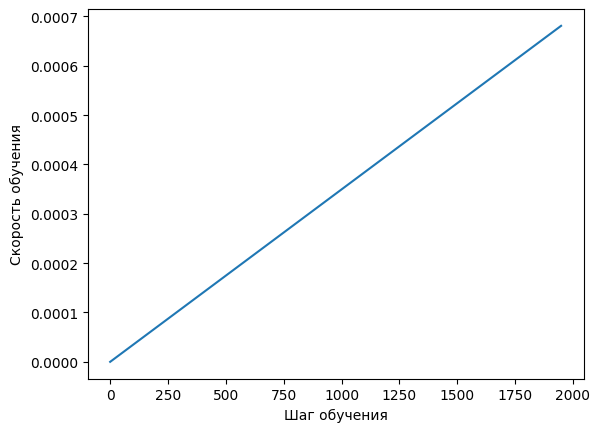

In [ ]:
plt.plot(learning_rate(tf.range(num_batches*EPOCHS, dtype=tf.float32)))
plt.ylabel('Скорость обучения')
plt.xlabel('Шаг обучения')

Text(0.5, 0, 'Шаг обучения')

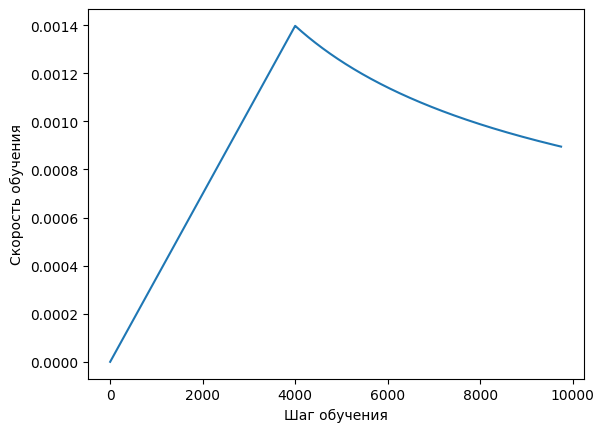

In [ ]:
plt.plot(learning_rate(tf.range(num_batches*EPOCHS*5, dtype=tf.float32)))
plt.ylabel('Скорость обучения')
plt.xlabel('Шаг обучения')

In [ ]:
# Функция потерь с учетом маски
def masked_loss(label, pred):
  # Задаем маску, где метки не равны 0
  mask = label != 0
  # Определяем функцию потерь
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  # Важно чтобы mask и loss имели одинаковый тип данных
  mask = tf.cast(mask, dtype=loss.dtype)
  # Наложение маски на loss
  loss *= mask

  # Масштабирование потерь на маску
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# Функция точности с учетом маски
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  # Оценка совпадения метки и предсказания
  match = label == pred
  # Задаем маску, где метки не равны 0
  mask = label != 0

  # Логическое И
  match = match & mask

  # Преобразуем к одному типу и масштабирование совпадений на маску
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 3406s 9s/step - loss: 6.4125 - masked_accuracy: 0.0455 - val_loss: 4.8097 - val_masked_accuracy: 0.1961
Epoch 2/5
361/391 ━━━━━━━━━━━━━━━━━━━━ 4:15 9s/step - loss: 4.6947 - masked_accuracy: 0.1813

KeyboardInterrupt: 

In [ ]:
# Сохранение модели
transformer.save('dz_38.keras')

In [ ]:
# Загрузка модели
from tensorflow.keras.models import load_model

loaded_model = load_model('my_model.h5')

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):

    assert isinstance(sentence, tf.Tensor) # Проверяем, что последовательность является тензором
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    # Введенное предложение написано на португальском языке
    encoder_input = sentence

    # Поскольку языком вывода является английский, инициализируйте вывод с помощью токена [START]
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # Здесь требуется  tf.TensorArray` (вместо списка Python), чтобы динамический цикл
    # можно было отследить с помощью `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      # на каждом шаге складываем выходные токены в массив для
      #  передачи на вход на следующем шаге
      output = tf.transpose(output_array.stack())
      # передаем в трансформер для предсказания токены
      predictions = self.transformer([encoder_input, output], training=False)

      # Выбираем последний токен из измерения `seq_len`
      predictions = predictions[:, -1:, :]  # Форма `(batch_size, 1, vocab_size)`.

      # Предсказанный токен
      predicted_id = tf.argmax(predictions, axis=-1)

      # Объединяем `predicted_id` с выходными данными, которые передаются
      # декодеру в качестве входных данных.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # Токены в текст
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` не позволяет нам использовать значения attention_weight, которые были
    # рассчитаны на последней итерации цикла.
    # Поэтому пересчитаем их вне цикла.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Фраза для перевода:":25s}: {sentence}')
  print(f'{"Предсказанный перевод:":25s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Оригинальный перевод":25s}: {ground_truth}')

In [ ]:
sentence = 'bu həll etməli olduğumuz problemdir.'
ground_truth = 'this is a problem we have to solve.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'və mənim qonşu evlərim bu fikri eşitdi.'
ground_truth = 'and my neighboring homes heard about this idea.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'buna görə də baş vermiş bəzi sehrli şeylərin bəzi hekayələrini çox tez sizinlə paylaşacağam.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'bu, mənim yazdığım ilk kitabdır”.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # Пропускаем токен `[START]`
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0  # номер головы
# Форма attention_weights: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0) # убираем нулевое измерение тензора
attention = attention_heads[head] # выбираем нужную голову
attention.shape

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.1

EPOCHS = 3

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # Форма оценок внимания: (batch, heads, target_seq, input_seq)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
num_batches = 0
for (batch, (_,_)) in enumerate(train_batches):
  num_batches = batch
print(num_batches)

In [ ]:
plt.plot(learning_rate(tf.range(num_batches*EPOCHS, dtype=tf.float32)))
plt.ylabel('Скорость обучения')
plt.xlabel('Шаг обучения')

In [ ]:
plt.plot(learning_rate(tf.range(num_batches*EPOCHS*5, dtype=tf.float32)))
plt.ylabel('Скорость обучения')
plt.xlabel('Шаг обучения')

In [ ]:
def masked_loss(label, pred):
  # Задаем маску, где метки не равны 0
  mask = label != 0
  # Определяем функцию потерь
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  # Важно чтобы mask и loss имели одинаковый тип данных
  mask = tf.cast(mask, dtype=loss.dtype)
  # Наложение маски на loss
  loss *= mask

  # Масштабирование потерь на маску
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# Функция точности с учетом маски
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  # Оценка совпадения метки и предсказания
  match = label == pred
  # Задаем маску, где метки не равны 0
  mask = label != 0

  # Логическое И
  match = match & mask

  # Преобразуем к одному типу и масштабирование совпадений на маску
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):

    assert isinstance(sentence, tf.Tensor) # Проверяем, что последовательность является тензором
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    # Введенное предложение написано на португальском языке
    encoder_input = sentence

    # Поскольку языком вывода является английский, инициализируйте вывод с помощью токена [START]
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # Здесь требуется  tf.TensorArray` (вместо списка Python), чтобы динамический цикл
    # можно было отследить с помощью `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      # на каждом шаге складываем выходные токены в массив для
      #  передачи на вход на следующем шаге
      output = tf.transpose(output_array.stack())
      # передаем в трансформер для предсказания токены
      predictions = self.transformer([encoder_input, output], training=False)

      # Выбираем последний токен из измерения `seq_len`
      predictions = predictions[:, -1:, :]  # Форма `(batch_size, 1, vocab_size)`.

      # Предсказанный токен
      predicted_id = tf.argmax(predictions, axis=-1)

      # Объединяем `predicted_id` с выходными данными, которые передаются
      # декодеру в качестве входных данных.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # Токены в текст
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` не позволяет нам использовать значения attention_weight, которые были
    # рассчитаны на последней итерации цикла.
    # Поэтому пересчитаем их вне цикла.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Фраза для перевода:":25s}: {sentence}')
  print(f'{"Предсказанный перевод:":25s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Оригинальный перевод":25s}: {ground_truth}')

In [ ]:
sentence = 'bu həll etməli olduğumuz problemdir.'
ground_truth = 'this is a problem we have to solve.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'və mənim qonşu evlərim bu fikri eşitdi.'
ground_truth = 'and my neighboring homes heard about this idea.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'buna görə də baş vermiş bəzi sehrli şeylərin bəzi hekayələrini çox tez sizinlə paylaşacağam.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'bu, mənim yazdığım ilk kitabdır”.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

#Ожидаемые результаты
## Модель с 8 головами:

Может лучше захватывать сложные зависимости в данных.

Может дать более высокое качество перевода, особенно для длинных или сложных предложений.

Требует больше вычислительных ресурсов и времени на обучение.

## Модель с 4 головами:

Быстрее обучается и требует меньше памяти.

Может быть достаточно для простых датасетов или задач.

Качество перевода может быть немного ниже, чем у модели с 8 головами.